In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.graph_utils import JunctionTree
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


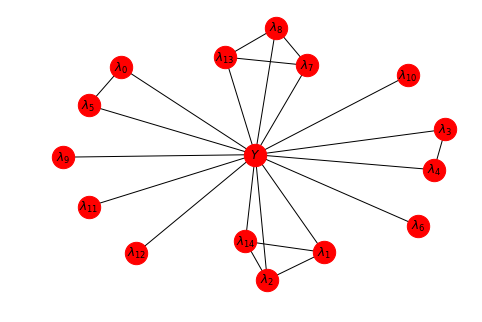

In [2]:
M = 15
N_CLUSTERS = 10
deps_graph = ClusterDependencies(M, N_CLUSTERS)
# deps_graph = ChainDependencies(M)
deps_graph.draw()

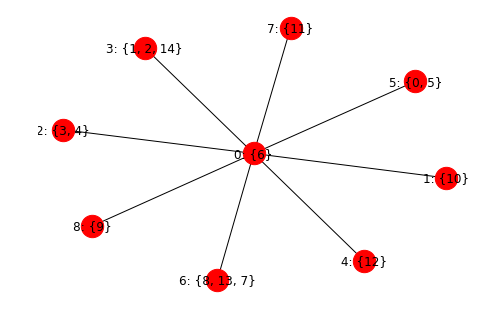

In [3]:
N = 1000 # Not used yet...
K = 2
HIGHER_ORDER_CLIQUES = True

data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
data.jt.draw()

### Computing entries across cliques

Say we want to compute marginals involving neighboring cliques $C_1$ and $C_2$; we have:
$$
P(C_1, C_2)
= P(C_1, C_2|S_{1,2}) P(S_{1,2})
= P(C_1|S_{1,2}) P(C_2|S_{1,2}) P(S_{1,2})
= \frac{P(C_1) P(C_2) }{ P(S_{1,2}) }
$$

In [4]:
query = {0:2, 1:1, M:1}

In [5]:
%time data.P_marginal(query)

CPU times: user 6.05 ms, sys: 286 µs, total: 6.33 ms
Wall time: 6.08 ms


0.1052999394698033

In [6]:
%%time
p = data.P_marginal_brute_force(query)
print(p)

0.10529993946980457
CPU times: user 2.97 s, sys: 5.45 ms, total: 2.98 s
Wall time: 2.98 s


In [7]:
data.P_marginal({M:1})

0.2620367211630437

In [8]:
data.P_marginal_brute_force({M:1})

0.26203672116304627

## Trying to recover the clique marginals

We start with:
$$
K_O = \Sigma_O^{-1} + \Sigma_O^{-1}\Sigma_{OH} \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1} \Sigma_{OH}^T\Sigma_O^{-1}
$$
and set:
$$
ZZ^T = \Sigma_O^{-1}\Sigma_{OH} \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1} \Sigma_{OH}^T\Sigma_O^{-1}
$$

Let $JJ^T = \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1}$; then $Z = \Sigma_O^{-1}\Sigma_{OH}J$.

Now our question is: suppose we've estimated $Z$, how do we recover $\Sigma_{OH}$ (which **note is not $\mu$, but we can recover $\mu$ directly from this given the labeling rates and class balance**).
We start by trying to recover an intermediate quantity:
$$
Q 
= \Sigma_{OH} \Sigma_H^{-1} \Sigma_{OH}^T
= \left( \Sigma_O Z J^{-1} \right) \Sigma_H^{-1}  \left( \Sigma_O Z J^{-1} \right)^T
= \Sigma_O Z J^{-1} \Sigma_H^{-1} J^{-T} Z^T \Sigma_O
= \Sigma_O Z \left( J^T \Sigma_H J \right)^{-1} Z^T \Sigma_O
$$

Now we need to recover $J^T\Sigma_H J$... start by noting that:
$$
\Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH}
=
J^{-T}Z^T\Sigma_O\Sigma_O^{-1}\Sigma_OZJ^{-1}
=
J^{-T}Z^T\Sigma_OZJ^{-1}
$$
and
$$
JJ^T
= \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1}
$$
and thus
$$
(JJ^T)^{-1}
= \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH}
$$
and so
$$
J^T\Sigma_HJ
= I + J^T\Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH}J
$$

Putting these two expressions together we have:
$$
J^T\Sigma_HJ
= I + Z^T\Sigma_OZ
$$

So finally, we have:
$$
Q 
= \Sigma_O Z \left( I + Z^T\Sigma_OZ \right)^{-1} Z^T \Sigma_O
$$

In [9]:
%time sigma_O = data.get_sigma_O()

CPU times: user 1.06 s, sys: 10.4 ms, total: 1.07 s
Wall time: 1.08 s


In [10]:
np.linalg.cond(sigma_O)

12.169204618279203

In [11]:
class_balance = data.get_class_balance()
class_balance

array([0.26203672, 0.73796328])

In [12]:
lm = LabelModel(k=2)

lm.train(
    sigma_O=sigma_O,
    junction_tree=data.jt,
    class_balance=class_balance,
    lr=0.001,
    n_epochs=10000,
    print_every=1000
)

Estimating Z...
[E:0]	Train Loss: 453.19851685
[E:1000]	Train Loss: 0.00011350
[E:2000]	Train Loss: 0.00000197
[E:3000]	Train Loss: 0.00000004
[E:4000]	Train Loss: 0.00000000
[E:5000]	Train Loss: 0.00000000
[E:6000]	Train Loss: 0.00000000
[E:7000]	Train Loss: 0.00000000
[E:8000]	Train Loss: 0.00000000
[E:9000]	Train Loss: 0.00000000
[E:9999]	Train Loss: 0.00000000
Finished Training


In [15]:
# If we had L_aug, could get this as the diagonal of L_aug.T @ L_aug
lps = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
mu_est = lm.get_mu(lps, sign_flip=-1)

mu = data.get_mu()
np.hstack([mu_est, mu])

array([[0.47198843, 0.47198855],
       [0.35278069, 0.35278058],
       [0.38499508, 0.38499519],
       [0.2613688 , 0.26136901],
       [0.38015011, 0.38014974],
       [0.20688787, 0.20688782],
       [0.36101212, 0.36101213],
       [0.58158682, 0.58158762],
       [0.36446321, 0.36446326],
       [0.35393236, 0.35393249],
       [0.37641858, 0.37641885],
       [0.40524135, 0.40524135],
       [0.29864887, 0.29864886],
       [0.19551952, 0.19551881],
       [0.38678119, 0.3867813 ],
       [0.14594438, 0.14594433],
       [0.08299911, 0.08299912],
       [0.11633419, 0.11633419],
       [0.06979895, 0.0697989 ]])

In [16]:
np.mean(np.abs(mu - mu_est))

1.6805931388270456e-07